In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

##### Hyperparameters

In [21]:
image_size = 64 # change 64 --> 512
batch_size = 16
latent_size = 256 #change 128 --> 256--> 512
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
lr = 0.0002
epochs = 25

#### class to help in loading images from directory

In [22]:
class FaceDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [os.path.join(self.data_dir, fname) for fname in os.listdir(self.data_dir) if fname.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, idx
        


#### Loading Data

In [23]:
os.listdir('../input')

['flickrfaceshq-dataset-ffhq', 'face-mask-lite-dataset']

In [24]:
DATA_DIR = '../input/face-mask-lite-dataset/without_mask'
# We use flickr faces to train the model then later use face-mask lite to fine tune
# DATA_DIR = '../input/flickrfaceshq-dataset-ffhq'

In [25]:
transforms = T.Compose([ T.Resize(image_size), T.CenterCrop(image_size), T.ToTensor(), T.Normalize(*stats)])

In [26]:
data_set = FaceDataset(data_dir=DATA_DIR, transform=transforms)
train_dl = DataLoader(data_set, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [27]:
print('Total batches per epoch:', len(train_dl))

Total batches per epoch: 625


#### Plotting Helper functions to display images

In [28]:
from torchvision.utils import make_grid

In [29]:
def denorm(img_tensors):
    """
    denormalize image tensors
    """
    return img_tensors * stats[1][0] + stats[0][0]

In [82]:
def show_image(image):
    """
    display single image
    """
    fig, ax = plt.subplots(figsize=(4,4))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(denorm(image.detach()).squeeze(0).permute(1, 2, 0))
    
def show_images(images, nmax=64):
    """
    display images
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

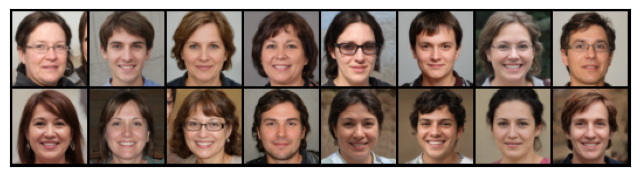

In [31]:
# test viewing images
show_batch(train_dl)

#### Defining helper functions and class to load data to device, we use yield to save on memory

In [33]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [34]:
# setting device
device = get_default_device()
device

device(type='cuda')

#### We know move our train dl to Device Data Loader for automatic transfer of batches to device (GPU if available)

In [35]:
train_dl = DeviceDataLoader(train_dl, device)

#### Defining Discriminator Network

In [36]:
# copy disc
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
    
        self.model = nn.Sequential(
            
            # in: 3 x 64 x 64
        
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32
        
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16
        
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8
        
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4
        
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1
        
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    

##### Initializing and moving discriminator to device

In [19]:
discriminator = Discriminator()
discriminator = to_device(discriminator, device)

#### Defining Generator Network

In [37]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model =  nn.Sequential(
            # in: latent_size x 1 x 1
        
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4
        
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8
        
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16
        
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32
        
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )

    def forward(self, x):
        return self.model(x)


##### Initializing generator and moving it to device

In [21]:
generator = Generator()
generator = to_device(generator, device)

##### Sample generated images

torch.Size([512, 3, 64, 64])
CPU times: user 414 ms, sys: 114 ms, total: 528 ms
Wall time: 903 ms


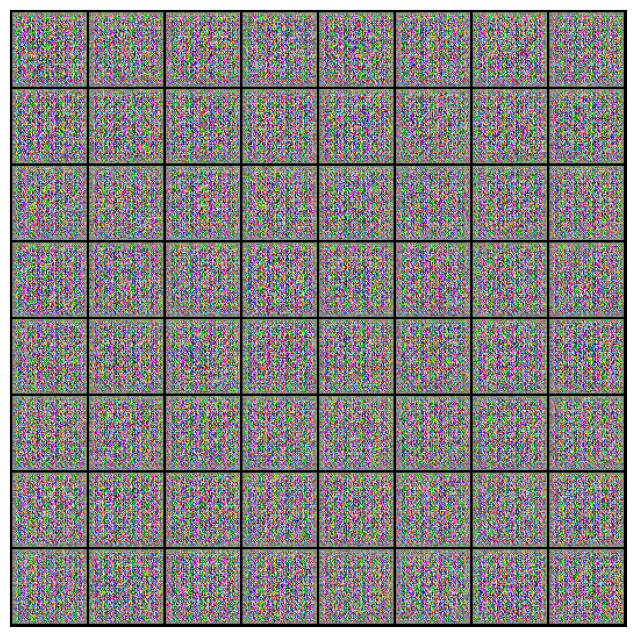

In [22]:
%%time
xb = torch.randn(batch_size, latent_size, 1, 1, device=device) # random latent tensors (noise)
fake_images = generator(xb).cpu()
print(fake_images.shape)
show_images(fake_images)

**Loading Pretrained Models and viewing sample generations**

In [42]:
gen_name = 'first_gen.pth'
generator = load_checkpoint(filepath=gen_name)

disc_name = 'first_disc.pth'
discriminator = load_checkpoint(filepath=disc_name)

torch.Size([64, 3, 64, 64])
CPU times: user 38.3 ms, sys: 5.32 ms, total: 43.6 ms
Wall time: 41 ms


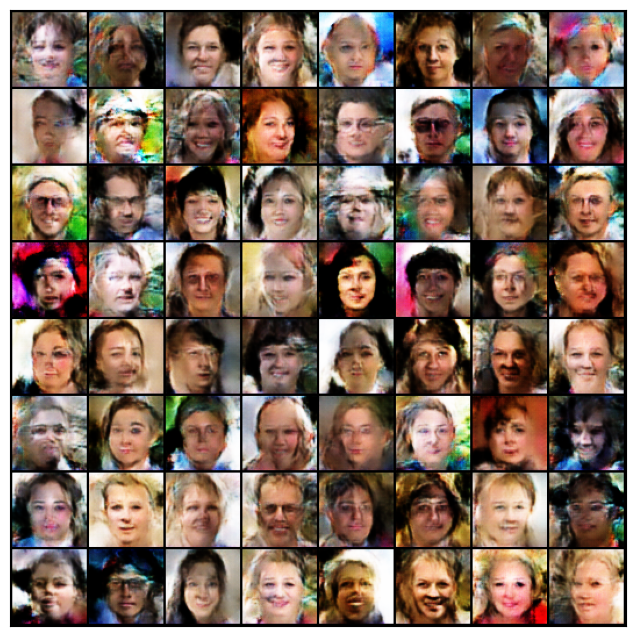

In [44]:
%%time
xb = torch.randn(64, latent_size, 1, 1, device=device) # random latent tensors (noise)
fake_images = generator(xb).cpu()
print(fake_images.shape)
show_images(fake_images)

#### Discriminator training function

In [45]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

#### Generator training function

In [46]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

#### Setting up functions to save generated images

In [47]:
from torchvision.utils import save_image

In [48]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

##### Function to save a sample generated image

In [49]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

##### Testing saving functionality

In [51]:

os.listdir('generated')
    
#      os.remove(os.path.join('./generated', file))

[]

In [54]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


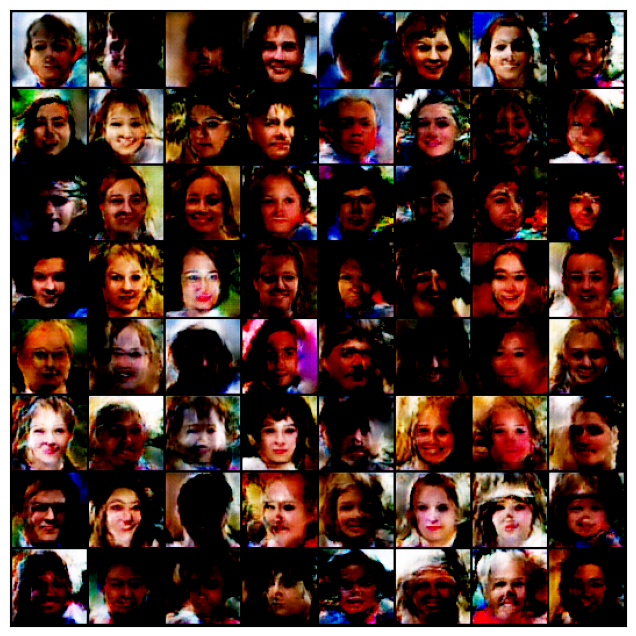

In [56]:
save_samples(0, fixed_latent)

#### Training function

In [57]:
from tqdm.notebook import tqdm

##### Optimizers

In [58]:
# Create optimizers
opt_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [59]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print(f"Epoch [{epoch+1}/{epochs}], loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f}, real_score: {real_score:.4f}, fake_score: {fake_score:.4f}")
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

#### Training GAN

In [60]:
history = fit(epochs, lr)

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 3.7255, loss_d: 0.2876, real_score: 0.8620, fake_score: 0.1034
Saving generated-images-0001.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.4135, loss_d: 0.7020, real_score: 0.9950, fake_score: 0.4556
Saving generated-images-0002.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 7.7468, loss_d: 0.6024, real_score: 0.9915, fake_score: 0.3970
Saving generated-images-0003.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 3.4801, loss_d: 0.0917, real_score: 0.9354, fake_score: 0.0203
Saving generated-images-0004.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 3.1500, loss_d: 0.1906, real_score: 0.8701, fake_score: 0.0378
Saving generated-images-0005.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 2.6013, loss_d: 0.2411, real_score: 0.8368, fake_score: 0.0502
Saving generated-images-0006.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 5.1003, loss_d: 0.1147, real_score: 0.9413, fake_score: 0.0423
Saving generated-images-0007.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.9459, loss_d: 0.1009, real_score: 0.9502, fake_score: 0.0446
Saving generated-images-0008.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 4.2821, loss_d: 0.0420, real_score: 0.9805, fake_score: 0.0215
Saving generated-images-0009.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 2.6832, loss_d: 0.3998, real_score: 0.8225, fake_score: 0.1475
Saving generated-images-0010.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 5.8228, loss_d: 0.4066, real_score: 0.8564, fake_score: 0.1591
Saving generated-images-0011.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 4.0722, loss_d: 0.3191, real_score: 0.9877, fake_score: 0.2051
Saving generated-images-0012.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 4.6696, loss_d: 0.1140, real_score: 0.9910, fake_score: 0.0859
Saving generated-images-0013.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 2.3564, loss_d: 0.2460, real_score: 0.8524, fake_score: 0.0572
Saving generated-images-0014.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 1.9655, loss_d: 1.0047, real_score: 0.5416, fake_score: 0.0196
Saving generated-images-0015.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 1.3017, loss_d: 0.6766, real_score: 0.6103, fake_score: 0.0124
Saving generated-images-0016.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 4.7499, loss_d: 0.1988, real_score: 0.9663, fake_score: 0.1376
Saving generated-images-0017.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 6.0043, loss_d: 0.9585, real_score: 0.9963, fake_score: 0.4316
Saving generated-images-0018.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 3.5966, loss_d: 0.2451, real_score: 0.8394, fake_score: 0.0346
Saving generated-images-0019.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 3.2895, loss_d: 0.1366, real_score: 0.9779, fake_score: 0.1020
Saving generated-images-0020.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 4.5523, loss_d: 0.0785, real_score: 0.9670, fake_score: 0.0385
Saving generated-images-0021.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 7.5438, loss_d: 0.2159, real_score: 0.9630, fake_score: 0.1146
Saving generated-images-0022.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 3.1564, loss_d: 0.3612, real_score: 0.7894, fake_score: 0.0346
Saving generated-images-0023.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 4.6310, loss_d: 0.4923, real_score: 0.9983, fake_score: 0.3125
Saving generated-images-0024.png


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 2.8350, loss_d: 0.4073, real_score: 0.7208, fake_score: 0.0025
Saving generated-images-0025.png


#### Unpacking training history

In [61]:
losses_g, losses_d, real_scores, fake_scores = history

##### Visualizing training loss

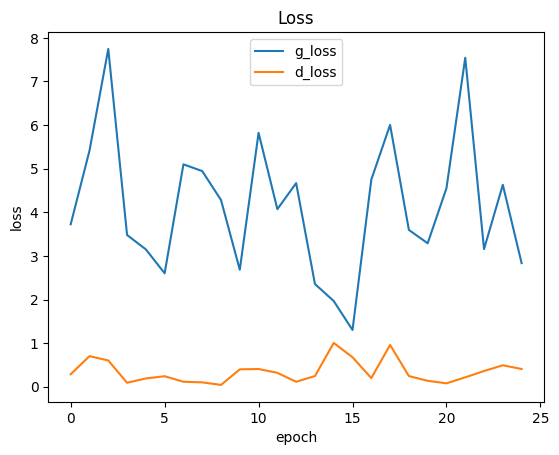

In [62]:
x = len(losses_g)
plt.plot(range(x), losses_g, label='g_loss')
plt.plot(range(x), losses_d, label='d_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()
plt.show()

##### Visualizing discriminator score on real and fake images 

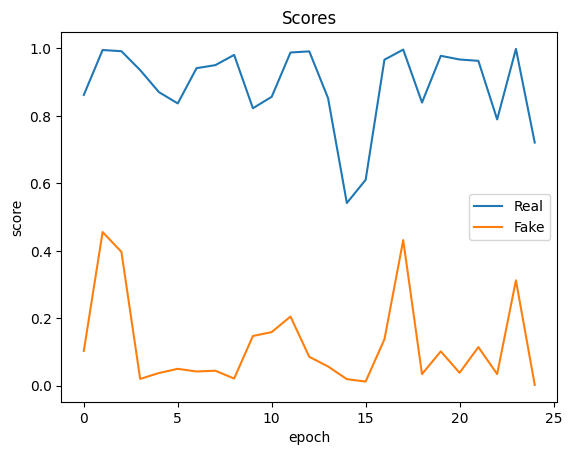

In [63]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

#### Viewing saved images

In [64]:
from IPython.display import Image

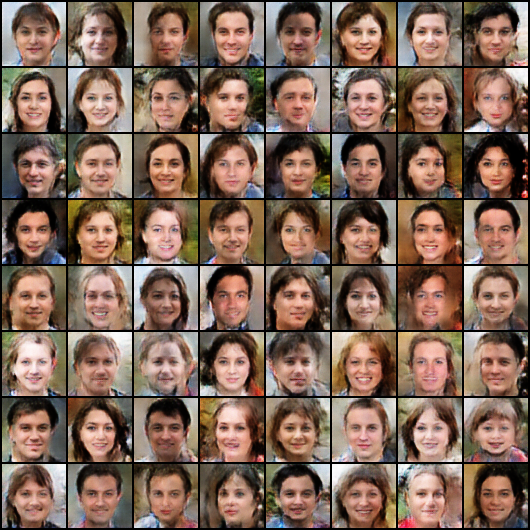

In [65]:
Image('./generated/generated-images-0001.png')

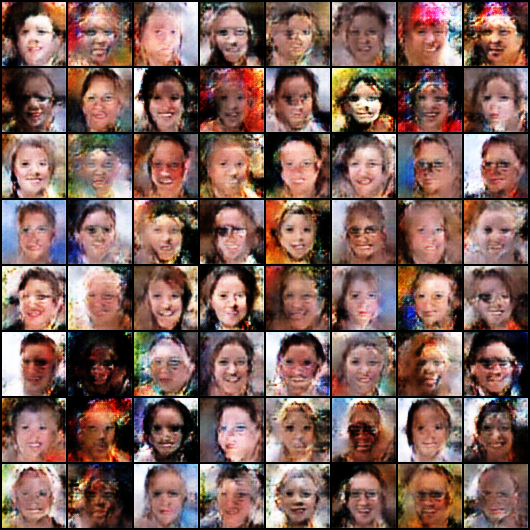

In [39]:
Image('./generated/generated-images-0015.png')

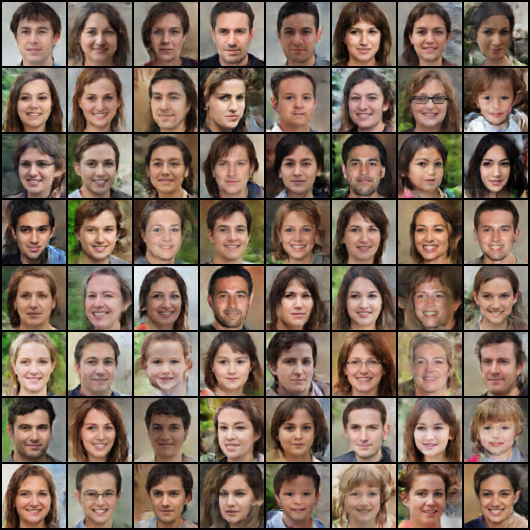

In [66]:
Image('./generated/generated-images-0025.png')

##### Creating a video of all generated images

In [67]:
import cv2

In [68]:
vid_fname = 'gans_training2.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


#### Generating new images

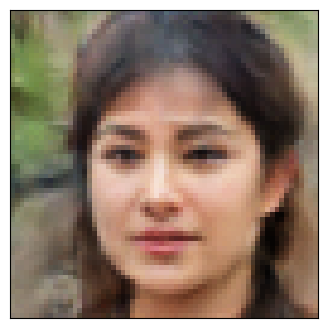

In [84]:
noise = torch.randn(1, latent_size, 1, 1, device=device)
with torch.no_grad():
    gen_image = generator(noise).cpu()

show_image(image=gen_image)

#### Saving Models

##### Functions to save and load models

In [71]:
def create_checkpoint(model, optimizer, model_name):
    checkpoint = {
        'model': model,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(checkpoint, f'{model_name}.pth')
    
    print('Model saved')
    return

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
#     for parameter in model.parameters():
#         parameter.requires_grad = False
    
#     model.eval()
    
    return model

##### Saving trained Generator

In [72]:
create_checkpoint(model=generator, optimizer=opt_g, model_name='second_gen')

Model saved


##### Saving trained Discriminator

In [73]:
create_checkpoint(model=discriminator, optimizer=opt_d, model_name='second_disc')

Model saved


##### Loading trained Generator

In [ ]:
gen_name = 'first_gen.pth'
generator = load_checkpoint(filepath=gen_name)

disc_name = 'first_disc.pth'
discriminator = load_checkpoint(filepath=disc_name)